In [1]:
import numpy as np
import sys, os, pickle, h5py, time

from iminuit import Minuit
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from astropy import coordinates as coord

# Load the Data

In [2]:
data_archive = h5py.File('../Data/Data_30keV.h5', 'r')

emins, emaxs = np.array(data_archive['BinEdges'])
flux_obs = np.array(data_archive['Flux'])
flux_err = np.array(data_archive['FluxError'])

ens_bkg, flux_bkg = np.array(data_archive['Background'])
ens_ABC, flux_ABC = np.array(data_archive['ABC_Model'])

data_archive.close()

ens_flux = (emins + emaxs)/2
binsize = emaxs - emins

In [3]:
def rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    interp_spectrum = np.interp(interp_energies, e, spectrum)
    
    interp_energies += E_Shift
    
    binned_spectrum = np.zeros_like(emins)
    for i in range(len(binned_spectrum)):
        
        min_index = np.searchsorted(interp_energies, emins[i])
        max_index = np.searchsorted(interp_energies, emaxs[i])
        
        binned_spectrum[i] = np.trapz(interp_spectrum[min_index:max_index], interp_energies[min_index:max_index])
    return np.nan_to_num(binned_spectrum) / binsize


# Make the rebinned background spectrum
bkg_spectrum = rebin(ens_bkg, flux_bkg)
bkg_spectrum[-1] = bkg_spectrum[-2] # Manually correct the last data point

In [4]:
def ChiSq(data, errors, bkg_spectrum, E_Shift):
    
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    Return the best fit signal amplitude and the change in chi^2 statistic.
    '''
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    
    obj = lambda A: np.sum((data - A*abc_spectrum - bkg_spectrum)**2 / errors**2)
    NullChiSq = obj(0)

    m = Minuit(obj, A = 0, limit_A = [None, None], error_A = .1,errordef = 1)
    m.migrad()
    
    fit = m.values['A']
    SignalChiSq = m.fval

    return fit, NullChiSq-SignalChiSq
    
    

In [5]:
E_Shifts = np.linspace(0, 23, 23*8+1)
Fit_Results = np.zeros((len(E_Shifts), 2))

for i in range(len(E_Shifts)):
    Fit_Results[i] = ChiSq(flux_obs, flux_err,bkg_spectrum ,E_Shifts[i])
    
    
    
best_fit_index = np.argmax(Fit_Results[:, 1])
best_fit_template = Fit_Results[best_fit_index, 0] * rebin(ens_ABC, flux_ABC, E_Shift = E_Shifts[best_fit_index])+bkg_spectrum#bkg_spectrum
best_fit_US = Fit_Results[0, 0] * rebin(ens_ABC, flux_ABC, E_Shift = 0.0)+bkg_spectrum#bkg_spectrum

In [6]:
mc_template = Fit_Results[0, 0] * rebin(ens_ABC, flux_ABC, E_Shift = 0)
mc_template += bkg_spectrum

Nmc = 5000
mc_data = stats.norm.rvs(loc = mc_template, scale = flux_err, size = (Nmc, len(mc_template)))


MC_Fit_Results = np.zeros((mc_data.shape[0], len(E_Shifts), 2))

for i in range(MC_Fit_Results.shape[0]):
    for j in range(MC_Fit_Results.shape[1]):
        MC_Fit_Results[i, j] = ChiSq(mc_data[i], flux_err , bkg_spectrum, E_Shifts[j])
    print(i)
clear_output()

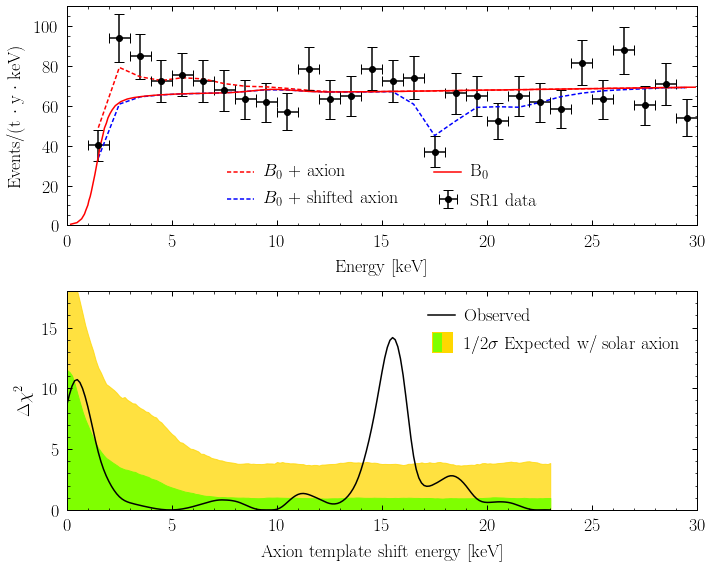

In [8]:
fig, axs = plt.subplots(nrows = 2,figsize=(10,8))

fontsize=18

axs[0].plot(ens_flux, best_fit_US, c='red', ls = '--', label = r'$B_0$ + axion')
axs[0].plot(ens_flux, best_fit_template, c='blue', ls = '--', label = r'$B_0$ + shifted axion')
axs[0].errorbar(ens_flux,flux_obs,xerr=binsize/2.,yerr=flux_err,fmt='o',color='k',capsize=5,label='SR1 data')
axs[0].plot(ens_bkg,flux_bkg,color='r',label='B$_0$')
axs[0].set_xlabel('Energy [keV]',fontsize=fontsize)
axs[0].set_ylabel(r'Events/(t $\cdot$ y $\cdot$ keV)',fontsize=fontsize)
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,110)
axs[0].legend(loc='lower center',frameon=False, fontsize =fontsize,ncol=2)




axs[1].plot(E_Shifts, Fit_Results[:, 1], c = 'black', zorder = 11, label = 'Unmasked')
#axs[1].plot(E_Shifts, Fit_Results_prof[:, 1], c = 'black',linestyle="dashed", zorder = 11, label = 'Unmasked')
#axs[1].plot(E_Shifts, Mask_Fit_Results[:, 1], c = 'grey', zorder = 10, label = 'Masked')


#plt.plot(E_Shifts, np.median(MC_Fit_Results[:, :, 3], axis = 0), '-s', c = 'black')
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 1], 0.0, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 1], .95, axis = 0), color = 'gold', alpha = .75)
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 1], 0.0, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 1], .68, axis = 0), color = 'chartreuse', alpha = 1.)


axs[1].set_ylim(0, 18)
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs[1].set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)
axs[1].legend()



msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = axs[1].get_legend_handles_labels()
handles1 = [handles[0], (m3 ,m4)]
labels1 = [r'Observed', r'$1/2\sigma$ Expected w/ solar axion']

axbox = axs[1].get_position()
x_value= -0.1
y_value= .65

legend1 = axs[1].legend(handles1,labels1, frameon=False, fontsize = fontsize)

axs[0].tick_params(axis='x', labelsize= fontsize)
axs[0].tick_params(axis='y', labelsize= fontsize)
axs[1].tick_params(axis='x', labelsize= fontsize)
axs[1].tick_params(axis='y', labelsize= fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace = .3)
plt.savefig('../Plots/Fig1.pdf')
plt.savefig('../Plots/Fig1.png')
plt.show()